# IFQ619 - Assignment 2
## Insight report

#### INSTRUCTIONS

1. Choose one question you were most knowledgeable about and are most comfortable with extending from Assignment 1.
2. Using your data analytics (Jupyter) notebook from Assignment 1, fix any problems that may prevent the analysis from being extended with an advanced technique.
3. Select one of the following advanced techniques appropriate to your chosen question: 
    For question 1 on structured data, select an advanced technique from Module 5: Bayesian analysis.
    For question 2 on unstructured and semi-structured data, select an advanced technique from Module 6: Topic modelling.
4. Apply the technique to the question, ensuring that you explain your decision-making in the markdown cells of the notebook.

In [1]:
# Complete the following cell with your details and run to produce your personalised header for this assignment

from IPython.core.display import display, HTML

first_name = "Melanie"
last_name = "Hand"
student_number = "11484594"

personal_header = "<h1>"+first_name+" "+last_name+" ("+student_number+")</h1>"
display(HTML(personal_header))

/tmp/ipykernel_269/943800205.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


---
## QUESTION

#### Question: 
What can the headlines from the Australian national broadcaster (the ABC) tell us about the concerns of the Australian public over time?

#### Data:
[A Million News Headlines](https://www.kaggle.com/therohk/million-headlines)



In [2]:
# import libraries for this question here
import pandas as pd
import json
import re
import string
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [3]:
import sys
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install pyLDAvis

In [4]:
pip install pattern3

Note: you may need to restart the kernel to use updated packages.


In [5]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.utils import tokenize
from gensim.utils import simple_preprocess
from gensim.utils import lemmatize
from gensim.corpora.textcorpus import remove_stopwords
from gensim.summarization import keywords
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim

### 1. Question

#### What can the headlines from the Australian national broadcaster (the ABC) tell us about the concerns of the Australian public over time?

This question is asking if or how the concerns of the Australian public have changed over time, based on headlines from the ABC. 

Public concerns and social attitudes clearly change over time. How and when they change could be of interest to policy makers, practitioners and advocates, who may use this information to inform policy decisions, or to advocate for change around a particular issue. 

Key questions for the analysis are:
1.	Which topics dominate the headlines for each year over this time period?
2.	Do the topics change over time?
To answer these questions, individual words within the headlines will be used as a proxy to determine the topic of a headline. The frequency and relevance of these words (topics) to a particular year will then be used as a measure for whether a topic dominates a given year.


### 2. Data

The data to be used for this analysis is online through the Kaggle website.

In [6]:
# Import the data
# Define the url
url = "https://www.kaggle.com/datasets/therohk/million-headlines?select=abcnews-date-text.csv"

# Read in the data as a csv file
news_data = pd.read_csv("data/abcnews-date-text.csv")

# Preview the data
news_data

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


The data is a dataframe with 2 columns: date and headline. This is a very large dataset, made up of 1,244,184 headlines between 2003 and 2021. Next I will explore the data further.

In [7]:
# Show information about the dataframe
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244184 entries, 0 to 1244183
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   publish_date   1244184 non-null  int64 
 1   headline_text  1244184 non-null  object
dtypes: int64(1), object(1)
memory usage: 19.0+ MB


The headlines are currently 'object' data type. 

To answer the question I will use TF-IDF analysis and word frequency analysis. But for this type of analysis, I will use tools that work with string data types. So I will first convert the headlines to 'string' data type.

In [8]:
# Create a new column which is the same content as the 'headline_text' column, but stored as string
news_data["headline_text_string"] = news_data["headline_text"].astype('string')

# Check to see if the data type has changed
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244184 entries, 0 to 1244183
Data columns (total 3 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   publish_date          1244184 non-null  int64 
 1   headline_text         1244184 non-null  object
 2   headline_text_string  1244184 non-null  string
dtypes: int64(1), object(1), string(1)
memory usage: 28.5+ MB


The dataframe now has a new column where the headlines are stored as string.

To look at how the headlines have changed over time, I will perform the analysis based on the year. This will reduce the dataset to a reasonable size, as there are 19 years to analyse. Any further granularity (e.g. month or day) will create a large dataset and will therefore be difficult to reveal any trends. 

Currently, however, the date is stored as an 8 digit integer (yyyymmdd) in one column. To enable analysis by year, I will create a new column that just contains the year.

In [9]:
# Copy the publish_date column into a new column called 'Year' and convert it to string
news_data["Year"] = news_data["publish_date"].apply(str)

In [10]:
# In the new Year column, display the year by selecting the first 4 integers of the year column
news_data["Year"] = news_data["Year"].str[0:4]

# Check to see if it has worked
news_data

,publish_date,headline_text,headline_text_string,Year
0,20030219,aba decides against community broadcasting lic...,aba decides against community broadcasting lic...,2003
1,20030219,act fire witnesses must be aware of defamation,act fire witnesses must be aware of defamation,2003
2,20030219,a g calls for infrastructure protection summit,a g calls for infrastructure protection summit,2003
3,20030219,air nz staff in aust strike for pay rise,air nz staff in aust strike for pay rise,2003
4,20030219,air nz strike to affect australian travellers,air nz strike to affect australian travellers,2003
...,...,...,...,...
1244179,20211231,two aged care residents die as state records 2...,two aged care residents die as state records 2...,2021
1244180,20211231,victoria records 5;919 new cases and seven deaths,victoria records 5;919 new cases and seven deaths,2021
1244181,20211231,wa delays adopting new close contact definition,wa delays adopting new close contact definition,2021
1244182,20211231,western ringtail possums found badly dehydrate...,western ringtail possums found badly dehydrate...,2021


In [11]:
# To get an understanding of the number of headlines per year, I will group the headlines by year and count the number of headlines in each year
headline_count = news_data.groupby('Year').count()
headline_count

,publish_date,headline_text,headline_text_string
Year,,,
2003,63997,63997,63997
2004,72674,72674,72674
2005,73124,73124,73124
2006,66901,66901,66901
2007,77174,77174,77174
2008,79991,79991,79991
2009,76444,76444,76444
2010,74931,74931,74931
2011,77778,77778,77778


In [12]:
# Export the tables as csv for the insights report
file_path = "data/headline_count.csv"
headline_count.to_csv(file_path)

### 3 Analysis

To answer question 1 and determine which topics dominate the headlines for a given year, a Term Frequency – Inverse Document Frequency (TF-IDF) analysis was performed. TF-IDF is a statistical measure that assesses how relevant a word is to a document, in a collection of documents. It incorporates two measures:
1.	How frequent a word is in a given document;
2.	How unique that word is to a document, within a collection of documents (a corpus)
In the context of this analysis, headlines from each year were treated as individual documents, and the total collection of headlines was the corpus.


In [13]:
# Group by the headlines by year using groupby 
# Use join to join the headlines together, separated by a space
# This will concatenate the headlines from a given year into a single cell
news_data_by_year = news_data.groupby('Year')['headline_text'].apply(' '.join)

# Check that it has worked
news_data_by_year

Year
2003    aba decides against community broadcasting lic...
2004    9 dead as bomb ends aceh new years concert aba...
2005    10 killed in kashmir new year party called off...
2006    adelaide end losing streak adelaide notch 4 2 ...
2007    140 arrested in adelaide during new years 1976...
2008    2007 deadliest year yet for us troops in iraq ...
2009    2008 deadliest year for us forces in afghanist...
2010    12m degas stolen from museum 17 die in banglad...
2011    11 killed in nigerian market blast 15 drown in...
2012    abc entertainment abc sport abc weather act mo...
2013    abc business news and market analysis abc ente...
2014    abbott wants conversation on indigenous refere...
2015    1000s celebrate nye in adelaide 1984 qld cabin...
2016    1985 qld cabinet documents mabo decision 49ers...
2017    1986 queensland cabinet documents released act...
2018    10 us citizens 2 locals killed in costa rica p...
2019    after expo ministers approved an artificial is...
2020    a

In [14]:
# Convert to dataframe
news_data_by_year_df = news_data_by_year.reset_index()
news_data_by_year_df

,Year,headline_text
0,2003,aba decides against community broadcasting lic...
1,2004,9 dead as bomb ends aceh new years concert aba...
2,2005,10 killed in kashmir new year party called off...
3,2006,adelaide end losing streak adelaide notch 4 2 ...
4,2007,140 arrested in adelaide during new years 1976...
5,2008,2007 deadliest year yet for us troops in iraq ...
6,2009,2008 deadliest year for us forces in afghanist...
7,2010,12m degas stolen from museum 17 die in banglad...
8,2011,11 killed in nigerian market blast 15 drown in...
9,2012,abc entertainment abc sport abc weather act mo...


In [15]:
# Create a list of all the words in each merged headline and add it as a new column called 'Terms'
# simple_preprocess will remove stop words, but remove_stopwords will remove even more, so will do both
# Decided to use a minimum word length of 2 to maximise to maximise the number of words analysed, particularly given abbreviations were often present in the headlines. 
# Increasing the minimum word length may unintentionally exclude key words from the analysis.

news_data_by_year_df["Terms_min2"] = [remove_stopwords(simple_preprocess(headline,min_len=2)) for headline in news_data_by_year_df['headline_text']]

news_data_by_year_df

,Year,headline_text,Terms_min2
0,2003,aba decides against community broadcasting lic...,"[aba, decides, community, broadcasting, licenc..."
1,2004,9 dead as bomb ends aceh new years concert aba...,"[dead, bomb, ends, aceh, new, years, concert, ..."
2,2005,10 killed in kashmir new year party called off...,"[killed, kashmir, new, year, party, called, af..."
3,2006,adelaide end losing streak adelaide notch 4 2 ...,"[adelaide, end, losing, streak, adelaide, notc..."
4,2007,140 arrested in adelaide during new years 1976...,"[arrested, adelaide, new, years, govt, papers,..."
5,2008,2007 deadliest year yet for us troops in iraq ...,"[deadliest, year, troops, iraq, french, cars, ..."
6,2009,2008 deadliest year for us forces in afghanist...,"[deadliest, year, forces, afghanistan, dubbed,..."
7,2010,12m degas stolen from museum 17 die in banglad...,"[degas, stolen, museum, die, bangladesh, bus, ..."
8,2011,11 killed in nigerian market blast 15 drown in...,"[killed, nigerian, market, blast, drown, egypt..."
9,2012,abc entertainment abc sport abc weather act mo...,"[abc, entertainment, abc, sport, abc, weather,..."


In [16]:
# Create a dictionary of all the words in the terms column and their frequency

term_dict_2 = Dictionary(news_data_by_year_df['Terms_min2'])

In [17]:
# Convert the headlines to BoW format which is required for the tf-idf analysis

corpus_2 = [term_dict_2.doc2bow(terms) for terms in news_data_by_year_df['Terms_min2']]

In [18]:
# for the tf-idf analysis, fit a tf-idf model to the corpus
model_2 = TfidfModel(corpus_2)

In [19]:
# Create a function to get the top 5 most relevant word for each year, based on the tf-idf analysis
def get_tfidf_2(index):
    term_values = [(term_dict_2[el[0]],el[1]) for el in model_2[corpus_2[index]] if el[1]>0]
    srt =  sorted(term_values, key=lambda x: x[1],reverse=True)
    return list(map(lambda x: x[0],srt[:5]))

In [20]:
# Test the function on the first document
get_tfidf_2(0)

['sars', 'amrozi', 'atsic', 'sorenstam', 'crean']

In [21]:
# Create a function to get the top 5 most relevant words for each year and their tfidf value
# Store as a dictionary
def get_tfidf_dict_2(index):
    term_values = [(term_dict_2[el[0]],el[1]) for el in model_2[corpus_2[index]] if el[1]>0]
    srt =  sorted(term_values, key=lambda x: x[1],reverse=True)
    return dict(srt[:5])

In [22]:
# Apply to the whole dataframe and add as a new column
news_data_by_year_df['tfidf_2'] = news_data_by_year_df.index.map(get_tfidf_2)
news_data_by_year_df['tfidf Dict_2'] = news_data_by_year_df.index.map(get_tfidf_dict_2)

news_data_by_year_df

,Year,headline_text,Terms_min2,tfidf_2,tfidf Dict_2
0,2003,aba decides against community broadcasting lic...,"[aba, decides, community, broadcasting, licenc...","[sars, amrozi, atsic, sorenstam, crean]","{'sars': 0.5137605325439106, 'amrozi': 0.11786..."
1,2004,9 dead as bomb ends aceh new years concert aba...,"[dead, bomb, ends, aceh, new, years, concert, ...","[najaf, fallujah, aristide, arafat, zarqawi]","{'najaf': 0.3395991920601233, 'fallujah': 0.33..."
2,2005,10 killed in kashmir new year party called off...,"[killed, kashmir, new, year, party, called, af...","[solon, wmc, ir, vsu, corby]","{'solon': 0.2605872626177856, 'wmc': 0.2373940..."
3,2006,adelaide end losing streak adelaide notch 4 2 ...,"[adelaide, end, losing, streak, adelaide, notc...","[kovco, awb, alkatiri, vaile, abcnews]","{'kovco': 0.4576004417864941, 'awb': 0.2379376..."
4,2007,140 arrested in adelaide during new years 1976...,"[arrested, adelaide, new, years, govt, papers,...","[haneef, auspine, pulp, woolmer, bhutto]","{'haneef': 0.626993770998867, 'auspine': 0.172..."
5,2008,2007 deadliest year yet for us troops in iraq ...,"[deadliest, year, troops, iraq, french, cars, ...","[wyd, haneef, fuelwatch, gustav, obama]","{'wyd': 0.4300448195300979, 'haneef': 0.239242..."
6,2009,2008 deadliest year for us forces in afghanist...,"[deadliest, year, forces, afghanistan, dubbed,...","[swine, ets, stimulus, ozcar, obama]","{'swine': 0.5266317636036533, 'ets': 0.2278592..."
7,2010,12m degas stolen from museum 17 die in banglad...,"[degas, stolen, museum, die, bangladesh, bus, ...","[summary, insulation, wikileaks, henjak, obama]","{'summary': 0.2460987733448771, 'insulation': ..."
8,2011,11 killed in nigerian market blast 15 drown in...,"[killed, nigerian, market, blast, drown, egypt...","[csg, gaddafi, kohler, yasi, regs]","{'csg': 0.18027113961271596, 'gaddafi': 0.1461..."
9,2012,abc entertainment abc sport abc weather act mo...,"[abc, entertainment, abc, sport, abc, weather,...","[varischetti, romney, csg, kohler, phils]","{'varischetti': 0.41589494413537387, 'romney':..."


In [23]:
# In Excel, I analysed the top 5 tf-idf words for each year and assigned to a topic category
# This will make it easier to identify patterns of themes
# Then assigned a colour to each category ready for visualiation
# Create new columns to capture the categories and colours
news_data_by_year_df['Category'] = (['mediumaquamarine','crimson','forestgreen','palevioletred','firebrick'],
['dodgerblue','dodgerblue','navy','navy','crimson'],
['darkcyan','palegreen','powderblue','powderblue','darkorange'],
['dodgerblue','chocolate','navy','firebrick','dimgrey'],
['crimson','chocolate','palegreen','palevioletred','navy'],
['violet','crimson','gold','indigo','navy'],
['mediumaquamarine','palegreen','gold','firebrick','navy'],
['darkgray','firebrick','deeppink','palevioletred','navy'],
['palegreen','navy','dimgrey','indigo','darkgray'],
['dimgrey','navy','palegreen','dimgrey','mediumslateblue'],
['dimgrey','palegreen','olive','dimgrey','dimgrey'],
['dimgrey','salmon','palegreen','dimgrey','palevioletred'],
['salmon','mediumslateblue','dimgrey','darkorange','salmon'],
['navy','mediumaquamarine','dodgerblue','navy','dimgrey'],
['palevioletred','indigo','darkcyan','navy','palevioletred'],
['navy','navy','navy','magenta','palevioletred'],
['navy','palevioletred','navy','darkcyan','dimgrey'],
['mediumaquamarine','mediumaquamarine','gold','navy','mediumaquamarine'],
['mediumaquamarine','mediumaquamarine','mediumaquamarine','mediumaquamarine','mediumaquamarine'])


news_data_by_year_df['Category colours']= (
['mediumaquamarine','crimson','forestgreen','palevioletred','firebrick'],
['dodgerblue','dodgerblue','navy','navy','crimson'],
['darkcyan','lawngreen','powderblue','powderblue','darkorange'],
['dodgerblue','chocolate','navy','firebrick','dimgrey'],
['crimson','chocolate','lawngreen','palevioletred','navy'],
['violet','crimson','gold','indigo','navy'],
['mediumaquamarine','lawngreen','gold','firebrick','navy'],
['darkgray','firebrick','deeppink','palevioletred','navy'],
['lawngreen','navy','dimgrey','indigo','darkgray'],
['dimgrey','navy','lawngreen','dimgrey','mediumslateblue'],
['dimgrey','lawngreen','olive','dimgrey','dimgrey'],
['dimgrey','salmon','lawngreen','dimgrey','palevioletred'],
['salmon','mediumslateblue','dimgrey','darkorange','salmon'],
['navy','mediumaquamarine','dodgerblue','navy','dimgrey'],
['palevioletred','indigo','darkcyan','navy','palevioletred'],
['navy','navy','navy','magenta','palevioletred'],
['navy','palevioletred','navy','darkcyan','dimgrey'],
['mediumaquamarine','mediumaquamarine','gold','navy','mediumaquamarine'],
['mediumaquamarine','mediumaquamarine','mediumaquamarine','mediumaquamarine','mediumaquamarine'])
news_data_by_year_df

,Year,headline_text,Terms_min2,tfidf_2,tfidf Dict_2,Category,Category colours
0,2003,aba decides against community broadcasting lic...,"[aba, decides, community, broadcasting, licenc...","[sars, amrozi, atsic, sorenstam, crean]","{'sars': 0.5137605325439106, 'amrozi': 0.11786...","(mediumaquamarine, crimson, forestgreen, palev...","(mediumaquamarine, crimson, forestgreen, palev..."
1,2004,9 dead as bomb ends aceh new years concert aba...,"[dead, bomb, ends, aceh, new, years, concert, ...","[najaf, fallujah, aristide, arafat, zarqawi]","{'najaf': 0.3395991920601233, 'fallujah': 0.33...","(dodgerblue, dodgerblue, navy, navy, crimson)","(dodgerblue, dodgerblue, navy, navy, crimson)"
2,2005,10 killed in kashmir new year party called off...,"[killed, kashmir, new, year, party, called, af...","[solon, wmc, ir, vsu, corby]","{'solon': 0.2605872626177856, 'wmc': 0.2373940...","(darkcyan, palegreen, powderblue, powderblue, ...","(darkcyan, lawngreen, powderblue, powderblue, ..."
3,2006,adelaide end losing streak adelaide notch 4 2 ...,"[adelaide, end, losing, streak, adelaide, notc...","[kovco, awb, alkatiri, vaile, abcnews]","{'kovco': 0.4576004417864941, 'awb': 0.2379376...","(dodgerblue, chocolate, navy, firebrick, dimgrey)","(dodgerblue, chocolate, navy, firebrick, dimgrey)"
4,2007,140 arrested in adelaide during new years 1976...,"[arrested, adelaide, new, years, govt, papers,...","[haneef, auspine, pulp, woolmer, bhutto]","{'haneef': 0.626993770998867, 'auspine': 0.172...","(crimson, chocolate, palegreen, palevioletred,...","(crimson, chocolate, lawngreen, palevioletred,..."
5,2008,2007 deadliest year yet for us troops in iraq ...,"[deadliest, year, troops, iraq, french, cars, ...","[wyd, haneef, fuelwatch, gustav, obama]","{'wyd': 0.4300448195300979, 'haneef': 0.239242...","(violet, crimson, gold, indigo, navy)","(violet, crimson, gold, indigo, navy)"
6,2009,2008 deadliest year for us forces in afghanist...,"[deadliest, year, forces, afghanistan, dubbed,...","[swine, ets, stimulus, ozcar, obama]","{'swine': 0.5266317636036533, 'ets': 0.2278592...","(mediumaquamarine, palegreen, gold, firebrick,...","(mediumaquamarine, lawngreen, gold, firebrick,..."
7,2010,12m degas stolen from museum 17 die in banglad...,"[degas, stolen, museum, die, bangladesh, bus, ...","[summary, insulation, wikileaks, henjak, obama]","{'summary': 0.2460987733448771, 'insulation': ...","(darkgray, firebrick, deeppink, palevioletred,...","(darkgray, firebrick, deeppink, palevioletred,..."
8,2011,11 killed in nigerian market blast 15 drown in...,"[killed, nigerian, market, blast, drown, egypt...","[csg, gaddafi, kohler, yasi, regs]","{'csg': 0.18027113961271596, 'gaddafi': 0.1461...","(palegreen, navy, dimgrey, indigo, darkgray)","(lawngreen, navy, dimgrey, indigo, darkgray)"
9,2012,abc entertainment abc sport abc weather act mo...,"[abc, entertainment, abc, sport, abc, weather,...","[varischetti, romney, csg, kohler, phils]","{'varischetti': 0.41589494413537387, 'romney':...","(dimgrey, navy, palegreen, dimgrey, mediumslat...","(dimgrey, navy, lawngreen, dimgrey, mediumslat..."


In [24]:
# Import the dataframe showing the top category based on the top tfidf term for each year
# This csv was prepared in Excel where I performed the category mapping
top_category_df = pd.read_csv("data/Top tfidf category per year.csv")
top_category_df

,Year,Topic,tf-idf score,Colour
0,2003,health,0.513761,mediumaquamarine
1,2004,international conflict,0.339599,dodgerblue
2,2005,human rights,0.260587,darkcyan
3,2006,international conflict,0.457600,dodgerblue
4,2007,terrorism,0.626994,crimson
5,2008,religion,0.430045,violet
6,2009,health,0.526632,mediumaquamarine
7,2010,australian politics,0.190537,firebrick
8,2011,environment,0.180271,palegreen
9,2012,international politics,0.238719,navy


For the second part of the analysis, I will look for the most frequent words within each headline.
The strength of TF-IDF analysis is in identifying terms characteristic of a particular document. However if a word appears with high frequency across all documents (years in this instance), there is a risk that this word may not be revealed through TF-IDF analysis. Therefore, to complement the TF-IDF analysis, word frequency was analysed across all of the headlines from each year.

In [25]:
# Define a function to calculate word frequency from the list of terms in the terms column
# Will again use a minimum word length of 2 to make sure no key terms are excluded from the analysis
# The function will retrieve the top 5 most frequent words
# A cut-off of 5 words per year was selected to provide insights into the most characteristic topics of the year, 
# while restricting the output to a manageable size for visualisation and analysis.

def word_freq (index):
    
    terms = news_data_by_year_df.loc[index,'Terms_min2']
    word_counts = {}
    
    for term in terms:
        if term in word_counts:
            word_counts[term] += 1
        else:
            word_counts[term] = 1
        
# sort the word_counts by counts (item 1 = second value)
# sorted_counts = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1],reverse=True)}
    sorted_counts = sorted(word_counts.items(), key=lambda item: item[1],reverse=True)
# Function to get top 5 relevant words (highest tfidf score)

    # term_values = [(vocab[el[0]],el[1]) for el in model[corpus[idx]] if el[1]>0]
# srt =  sorted(term_values, key=lambda x: x[1],reverse=True)
#     return list(map(lambda x: x[0],sorted_counts[:5]))
    return list(map(lambda x: x[0], sorted_counts[:5]))

In [26]:
# Test with one row
word_freq(18)

['covid', 'new', 'nsw', 'australia', 'says']

In [27]:
# Create a new column in the dataframe and add the five most frequent words for each year
news_data_by_year_df['Top 5 Most Frequent Terms'] = news_data_by_year_df.index.map(word_freq)
news_data_by_year_df

,Year,headline_text,Terms_min2,tfidf_2,tfidf Dict_2,Category,Category colours,Top 5 Most Frequent Terms
0,2003,aba decides against community broadcasting lic...,"[aba, decides, community, broadcasting, licenc...","[sars, amrozi, atsic, sorenstam, crean]","{'sars': 0.5137605325439106, 'amrozi': 0.11786...","(mediumaquamarine, crimson, forestgreen, palev...","(mediumaquamarine, crimson, forestgreen, palev...","[police, govt, new, man, council]"
1,2004,9 dead as bomb ends aceh new years concert aba...,"[dead, bomb, ends, aceh, new, years, concert, ...","[najaf, fallujah, aristide, arafat, zarqawi]","{'najaf': 0.3395991920601233, 'fallujah': 0.33...","(dodgerblue, dodgerblue, navy, navy, crimson)","(dodgerblue, dodgerblue, navy, navy, crimson)","[police, new, govt, man, council]"
2,2005,10 killed in kashmir new year party called off...,"[killed, kashmir, new, year, party, called, af...","[solon, wmc, ir, vsu, corby]","{'solon': 0.2605872626177856, 'wmc': 0.2373940...","(darkcyan, palegreen, powderblue, powderblue, ...","(darkcyan, lawngreen, powderblue, powderblue, ...","[police, govt, new, council, man]"
3,2006,adelaide end losing streak adelaide notch 4 2 ...,"[adelaide, end, losing, streak, adelaide, notc...","[kovco, awb, alkatiri, vaile, abcnews]","{'kovco': 0.4576004417864941, 'awb': 0.2379376...","(dodgerblue, chocolate, navy, firebrick, dimgrey)","(dodgerblue, chocolate, navy, firebrick, dimgrey)","[police, govt, new, man, council]"
4,2007,140 arrested in adelaide during new years 1976...,"[arrested, adelaide, new, years, govt, papers,...","[haneef, auspine, pulp, woolmer, bhutto]","{'haneef': 0.626993770998867, 'auspine': 0.172...","(crimson, chocolate, palegreen, palevioletred,...","(crimson, chocolate, lawngreen, palevioletred,...","[police, govt, man, new, water]"
5,2008,2007 deadliest year yet for us troops in iraq ...,"[deadliest, year, troops, iraq, french, cars, ...","[wyd, haneef, fuelwatch, gustav, obama]","{'wyd': 0.4300448195300979, 'haneef': 0.239242...","(violet, crimson, gold, indigo, navy)","(violet, crimson, gold, indigo, navy)","[police, govt, man, new, qld]"
6,2009,2008 deadliest year for us forces in afghanist...,"[deadliest, year, forces, afghanistan, dubbed,...","[swine, ets, stimulus, ozcar, obama]","{'swine': 0.5266317636036533, 'ets': 0.2278592...","(mediumaquamarine, palegreen, gold, firebrick,...","(mediumaquamarine, lawngreen, gold, firebrick,...","[police, man, interview, new, govt]"
7,2010,12m degas stolen from museum 17 die in banglad...,"[degas, stolen, museum, die, bangladesh, bus, ...","[summary, insulation, wikileaks, henjak, obama]","{'summary': 0.2460987733448771, 'insulation': ...","(darkgray, firebrick, deeppink, palevioletred,...","(darkgray, firebrick, deeppink, palevioletred,...","[interview, police, man, new, court]"
8,2011,11 killed in nigerian market blast 15 drown in...,"[killed, nigerian, market, blast, drown, egypt...","[csg, gaddafi, kohler, yasi, regs]","{'csg': 0.18027113961271596, 'gaddafi': 0.1461...","(palegreen, navy, dimgrey, indigo, darkgray)","(lawngreen, navy, dimgrey, indigo, darkgray)","[police, man, interview, new, flood]"
9,2012,abc entertainment abc sport abc weather act mo...,"[abc, entertainment, abc, sport, abc, weather,...","[varischetti, romney, csg, kohler, phils]","{'varischetti': 0.41589494413537387, 'romney':...","(dimgrey, navy, palegreen, dimgrey, mediumslat...","(dimgrey, navy, lawngreen, dimgrey, mediumslat...","[interview, police, new, man, abc]"


In [28]:
# Make a list of all of the top 5 most frequent terms for each year, and remove duplicates
frequent_words = list(set(sum((news_data_by_year_df['Top 5 Most Frequent Terms']).tolist(),[])))
frequent_words

['govt',
 'interview',
 'flood',
 'says',
 'coronavirus',
 'nsw',
 'australia',
 'covid',
 'man',
 'qld',
 'trump',
 'court',
 'australian',
 'police',
 'water',
 'new',
 'abc',
 'council']

In [29]:
# Remove some stop-words that aren't very informative: man, new, abc, says, interview
unwanted = {'man', 'new', 'abc', 'says', 'interview'}
frequent_words = [a for a in frequent_words if a not in unwanted]
frequent_words

['govt',
 'flood',
 'coronavirus',
 'nsw',
 'australia',
 'covid',
 'qld',
 'trump',
 'court',
 'australian',
 'police',
 'water',
 'council']

In [30]:
len(frequent_words)

13

In [31]:
# Add the whole word frequency dictionary to the dataframe
def word_freq3 (index):
    
    terms = news_data_by_year_df.loc[index,'Terms_min2']
    word_counts = {}
    
    for term in terms:
        if term in word_counts:
            word_counts[term] += 1
        else:
            word_counts[term] = 1
    return word_counts

In [32]:
# Create a new column in the dataframe and add the word frequency dictionary
news_data_by_year_df['Word Freq Dict'] = news_data_by_year_df.index.map(word_freq3)
news_data_by_year_df

,Year,headline_text,Terms_min2,tfidf_2,tfidf Dict_2,Category,Category colours,Top 5 Most Frequent Terms,Word Freq Dict
0,2003,aba decides against community broadcasting lic...,"[aba, decides, community, broadcasting, licenc...","[sars, amrozi, atsic, sorenstam, crean]","{'sars': 0.5137605325439106, 'amrozi': 0.11786...","(mediumaquamarine, crimson, forestgreen, palev...","(mediumaquamarine, crimson, forestgreen, palev...","[police, govt, new, man, council]","{'aba': 16, 'decides': 10, 'community': 248, '..."
1,2004,9 dead as bomb ends aceh new years concert aba...,"[dead, bomb, ends, aceh, new, years, concert, ...","[najaf, fallujah, aristide, arafat, zarqawi]","{'najaf': 0.3395991920601233, 'fallujah': 0.33...","(dodgerblue, dodgerblue, navy, navy, crimson)","(dodgerblue, dodgerblue, navy, navy, crimson)","[police, new, govt, man, council]","{'dead': 370, 'bomb': 337, 'ends': 160, 'aceh'..."
2,2005,10 killed in kashmir new year party called off...,"[killed, kashmir, new, year, party, called, af...","[solon, wmc, ir, vsu, corby]","{'solon': 0.2605872626177856, 'wmc': 0.2373940...","(darkcyan, palegreen, powderblue, powderblue, ...","(darkcyan, lawngreen, powderblue, powderblue, ...","[police, govt, new, council, man]","{'killed': 672, 'kashmir': 40, 'new': 2097, 'y..."
3,2006,adelaide end losing streak adelaide notch 4 2 ...,"[adelaide, end, losing, streak, adelaide, notc...","[kovco, awb, alkatiri, vaile, abcnews]","{'kovco': 0.4576004417864941, 'awb': 0.2379376...","(dodgerblue, chocolate, navy, firebrick, dimgrey)","(dodgerblue, chocolate, navy, firebrick, dimgrey)","[police, govt, new, man, council]","{'adelaide': 237, 'end': 295, 'losing': 46, 's..."
4,2007,140 arrested in adelaide during new years 1976...,"[arrested, adelaide, new, years, govt, papers,...","[haneef, auspine, pulp, woolmer, bhutto]","{'haneef': 0.626993770998867, 'auspine': 0.172...","(crimson, chocolate, palegreen, palevioletred,...","(crimson, chocolate, lawngreen, palevioletred,...","[police, govt, man, new, water]","{'arrested': 353, 'adelaide': 293, 'new': 1994..."
5,2008,2007 deadliest year yet for us troops in iraq ...,"[deadliest, year, troops, iraq, french, cars, ...","[wyd, haneef, fuelwatch, gustav, obama]","{'wyd': 0.4300448195300979, 'haneef': 0.239242...","(violet, crimson, gold, indigo, navy)","(violet, crimson, gold, indigo, navy)","[police, govt, man, new, qld]","{'deadliest': 1, 'year': 358, 'troops': 194, '..."
6,2009,2008 deadliest year for us forces in afghanist...,"[deadliest, year, forces, afghanistan, dubbed,...","[swine, ets, stimulus, ozcar, obama]","{'swine': 0.5266317636036533, 'ets': 0.2278592...","(mediumaquamarine, palegreen, gold, firebrick,...","(mediumaquamarine, lawngreen, gold, firebrick,...","[police, man, interview, new, govt]","{'deadliest': 4, 'year': 353, 'forces': 130, '..."
7,2010,12m degas stolen from museum 17 die in banglad...,"[degas, stolen, museum, die, bangladesh, bus, ...","[summary, insulation, wikileaks, henjak, obama]","{'summary': 0.2460987733448771, 'insulation': ...","(darkgray, firebrick, deeppink, palevioletred,...","(darkgray, firebrick, deeppink, palevioletred,...","[interview, police, man, new, court]","{'degas': 2, 'stolen': 148, 'museum': 45, 'die..."
8,2011,11 killed in nigerian market blast 15 drown in...,"[killed, nigerian, market, blast, drown, egypt...","[csg, gaddafi, kohler, yasi, regs]","{'csg': 0.18027113961271596, 'gaddafi': 0.1461...","(palegreen, navy, dimgrey, indigo, darkgray)","(lawngreen, navy, dimgrey, indigo, darkgray)","[police, man, interview, new, flood]","{'killed': 556, 'nigerian': 11, 'market': 471,..."
9,2012,abc entertainment abc sport abc weather act mo...,"[abc, entertainment, abc, sport, abc, weather,...","[varischetti, romney, csg, kohler, phils]","{'varischetti': 0.41589494413537387, 'romney':...","(dimgrey, navy, palegreen, dimgrey, mediumslat...","(dimgrey, navy, lawngreen, dimgrey, mediumslat...","[interview, police, new, man, abc]","{'abc': 1701, 'entertainm

In [33]:
# Create a version of the dataframe with only the top5 tfidf and top5 frequency terms to export as csv for the insights report
df_for_export = news_data_by_year_df.drop(['headline_text','Terms_min2','Word Freq Dict'], axis=1)
file_path = "data/headline_topics.csv"
df_for_export.to_csv(file_path)

In [34]:
# Create new dataframe that will collect the frequency of each common word for each year
term_frequencies_df = pd.DataFrame()
term_frequencies_df['Term'] = frequent_words

In [35]:
# Define a function to return frequncies of common words for each year
def find_common_words(index):
    
    column_name = news_data_by_year_df.loc[index,'Year']
    freq_list = []
    for j in range (len(frequent_words)):
        freq_list.append(news_data_by_year_df.loc[index,'Word Freq Dict'].get(frequent_words[j],0))
    term_frequencies_df[column_name] = freq_list

In [36]:
# Run the function across each of the 19 years in the dataframe
for i in range(19):
    find_common_words(i)

In [37]:
term_frequencies_df

,Term,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,govt,1933,1991,2408,2272,2670,2546,1418,427,240,220,249,212,156,129,94,34,19,39,47
1,flood,76,113,102,118,220,230,237,441,1280,484,527,167,158,165,85,62,58,69,51
2,coronavirus,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8385,562
3,nsw,822,732,550,526,958,731,531,388,771,779,1308,1519,1525,1067,760,540,607,1636,795
4,australia,505,581,586,488,407,475,580,536,625,937,1162,1486,1678,1464,1304,1043,953,1846,764
5,covid,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3248,1948
6,qld,703,730,642,691,1042,1280,1064,478,436,649,1245,971,733,496,328,307,187,403,218
7,trump,1,3,4,4,2,2,3,6,10,9,1,2,53,770,1359,1099,710,993,279
8,court,1088,1045,1029,947,1257,1278,1139,1168,1032,1238,1361,1129,1058,906,726,528,489,596,173
9,australian,297,434,452,361,244,319,386,377,478,946,1146,1344,1510,1260,988,968,782,896,461


In [38]:
# Transpose the data frame ready for visualisation
term_frequencies_df_T = term_frequencies_df.T
term_frequencies_df_T

# Use row 1 as column header and then delete row 1
term_frequencies_df_T.columns = term_frequencies_df_T.iloc[0]
term_frequencies_df_T = term_frequencies_df_T[1:]
term_frequencies_df_T

Term,govt,flood,coronavirus,nsw,australia,covid,qld,trump,court,australian,police,water,council
2003,1933,76,0,822,505,0,703,1,1088,297,2335,707,1290
2004,1991,113,0,732,581,0,730,3,1045,434,2767,795,1460
2005,2408,102,0,550,586,0,642,4,1029,452,2934,841,1643
2006,2272,118,0,526,488,0,691,4,947,361,2458,1114,1314
2007,2670,220,0,958,407,0,1042,2,1257,244,3330,1703,1521
2008,2546,230,0,731,475,0,1280,2,1278,319,3140,977,1121
2009,1418,237,0,531,580,0,1064,3,1139,386,2669,893,1011
2010,427,441,0,388,536,0,478,6,1168,377,2405,897,1081
2011,240,1280,0,771,625,0,436,10,1032,478,2104,759,951
2012,220,484,0,779,937,0,649,9,1238,946,2249,683,1058


### 4 Visualisation

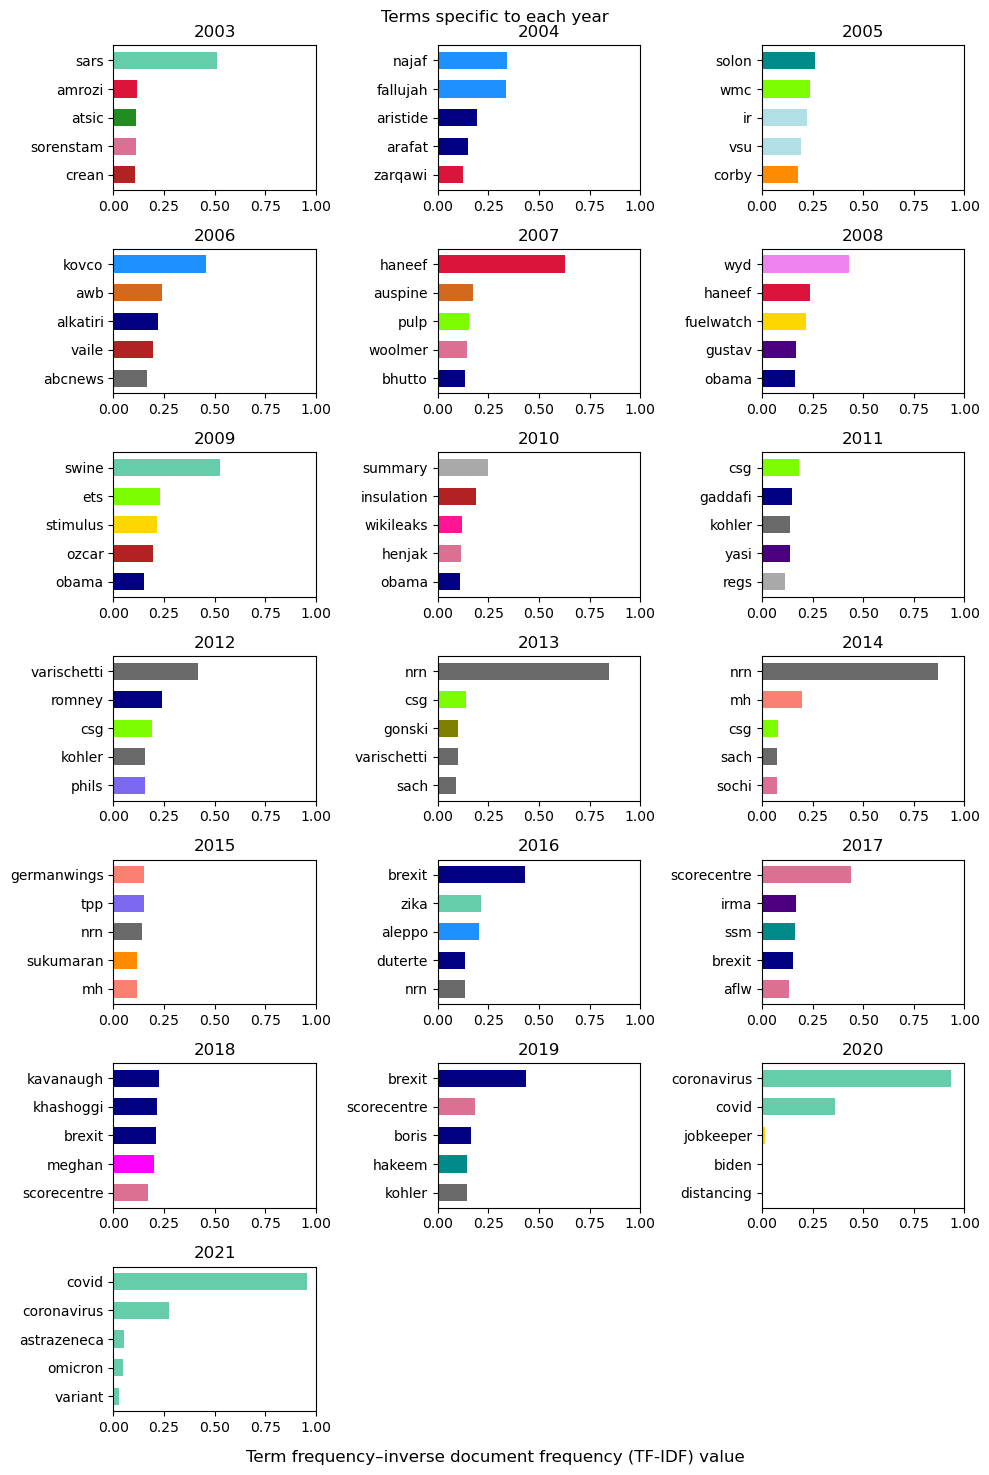

In [39]:
# Convert each to lists ready for visualisation
# First test with the first document (row in df)
fig=plt.figure(figsize=(10,15), layout='tight')
fig.supxlabel('Term frequency–inverse document frequency (TF-IDF) value')
for i in range(19):

    plt.subplot(7,3,i+1) # Define 5 rows with 4 columns of plots, this is plot 1
    
    

    y = list(news_data_by_year_df.loc[i,'tfidf Dict_2'].keys()) # List of the words categories
    x = list(news_data_by_year_df.loc[i,'tfidf Dict_2'].values()) # List of the tf-idf values
    colours = list(news_data_by_year_df.loc[i,'Category colours'])
    

    plt.suptitle('Terms specific to each year') # Set a title for full plot
 
    width = 0.6

    plt.barh(y, x, width, color = colours) # Bar chart of the tech sector responses
    plt.title(news_data_by_year_df.loc[i,'Year']) # Set a title for sub-plot
    plt.yticks(fontsize = 10) # Rotate labels so they can be seen
    plt.xlim(0,1) # Set the y axis limits to make the subplots comparable
    plt.gca().invert_yaxis()
plt.savefig('data/fig.jpg')

In [40]:
# Created a seaprate table in Excel that defines the topic categories and the colour mapping
# Upload the table of category and colour mappings to use in the legend

legend_df = pd.read_csv("data/legend_table.csv")

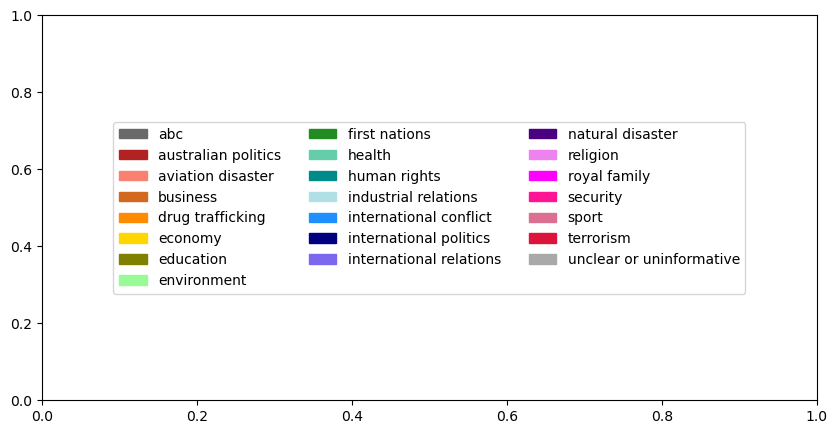

In [41]:
# Create a custom legend for the above plot
# Based on the separate table uploaded above
colours = list(legend_df['Colour'])
texts = list(legend_df['Category'])
patches = [mpatches.Patch(color=colours[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
fig=plt.figure(figsize=(10,5))
plt.legend(handles=patches, bbox_to_anchor=(0.5, 0.5), loc='center', ncol=3 )
plt.savefig('data/legend.jpg')

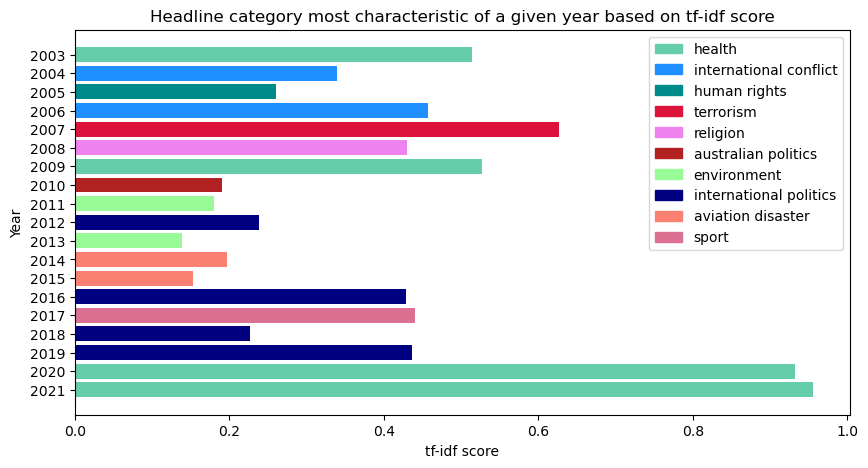

In [42]:
# Will also plot just the top category for each year and its tfidf score
x = top_category_df["Year"].tolist()
y = top_category_df["tf-idf score"].tolist()
cat_colours = top_category_df["Colour"].tolist()
topic_names = top_category_df["Topic"].tolist()
unique_colours = ['mediumaquamarine', 'dodgerblue', 'darkcyan', 'crimson', 'violet', 'firebrick', 'palegreen', 'navy', 'salmon', 'palevioletred']
unique_topics = ['health', 'international conflict', 'human rights', 'terrorism', 'religion', 'australian politics', 'environment', 'international politics', 'aviation disaster', 'sport']

fig = plt.figure(figsize=(10,5))
width = 0.8

plt.barh(x, y, width, color = cat_colours) # Bar chart of the tech sector responses
plt.title('Headline category most characteristic of a given year based on tf-idf score') # Set a title for sub-plot

plt.yticks(np.arange(2003, 2022, step = 1))
plt.xlabel('tf-idf score')
plt.ylabel('Year')
plt.gca().invert_yaxis()
legend_patches = [mpatches.Patch(color=unique_colours[i], label="{:s}".format(unique_topics[i]) ) for i in range(len(unique_topics)) ]
plt.legend(handles=legend_patches, ncol=1 )
plt.savefig('data/top_categories.jpg')

 

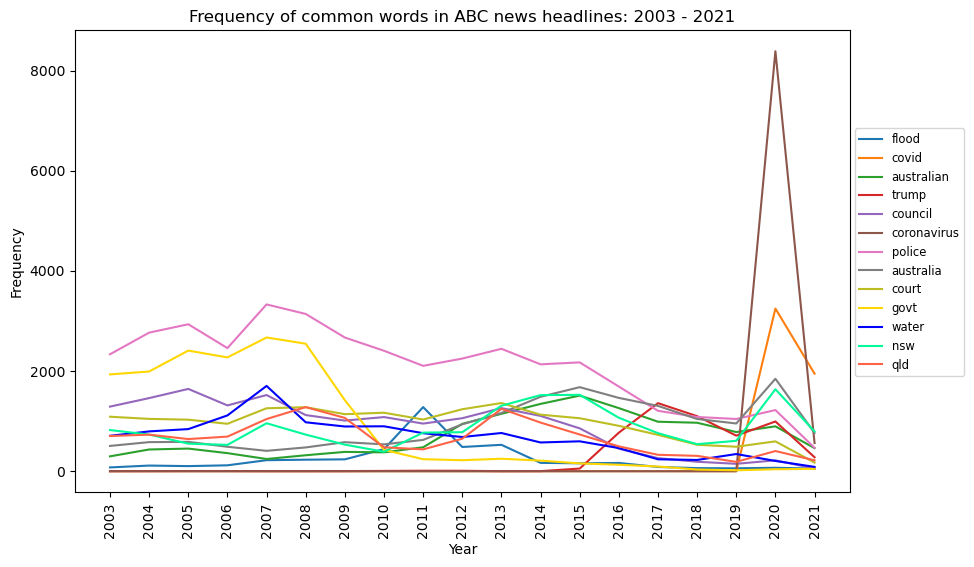

In [43]:
# For the word frequency analysis, decided to plot the most frequnt terms as a line chart over time
# Plot each word over time
fig1=plt.figure(figsize=(10,6))
plt.plot(term_frequencies_df_T["flood"], label = "flood")
plt.plot(term_frequencies_df_T["covid"], label = "covid")
plt.plot(term_frequencies_df_T["australian"], label = "australian")
plt.plot(term_frequencies_df_T["trump"], label = "trump")
plt.plot(term_frequencies_df_T["council"], label = "council")
plt.plot(term_frequencies_df_T["coronavirus"], label = "coronavirus")
plt.plot(term_frequencies_df_T["police"], label = "police")
plt.plot(term_frequencies_df_T["australia"], label = "australia")
plt.plot(term_frequencies_df_T["court"], label = "court")
plt.plot(term_frequencies_df_T["govt"], label = "govt", color = "gold")
plt.plot(term_frequencies_df_T["water"], label = "water", color = "blue")
plt.plot(term_frequencies_df_T["nsw"], label = "nsw", color = "mediumspringgreen")
plt.plot(term_frequencies_df_T["qld"], label = "qld", color = "tomato")
plt.legend(loc = 'upper right', bbox_to_anchor = (1.155,0.8), fontsize = 'small') # Display the legend
plt.xlabel('Year') # X-axis label
plt.xticks(rotation = 90) # Rotate the x-axis labels by 90 degrees
plt.ylabel('Frequency') # Y-axis label
plt.title('Frequency of common words in ABC news headlines: 2003 - 2021') # Plot title
plt.savefig('fig1.jpg')

### 5 Insights

Insights from this analysis are covered in the separate Insights Report.